In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [36]:
import pandas as pd
data = pd.read_csv(r'C:\Users\Asus\Desktop\Project2\hmnist_28_28_RGB.csv')

In [37]:
y = data['label']
x = data.drop(columns = ['label'])

In [4]:
# Exploratory Data Analysis (EDA)

tabular_data = pd.read_csv(r'C:\Users\Asus\Desktop\Project2\HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [38]:
classes = {4: ('nv', ' melanocytic nevi'), 
           6: ('mel', 'melanoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           3: ('df', 'dermatofibroma')}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

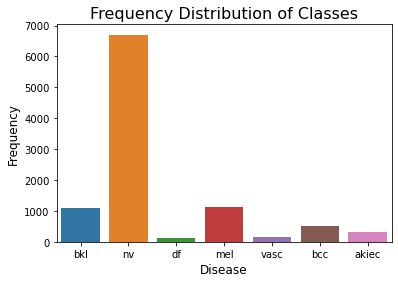

In [39]:
"""Frequency Distribution of Classes"""

sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

Text(0.5, 1.0, 'Gender of Patient')

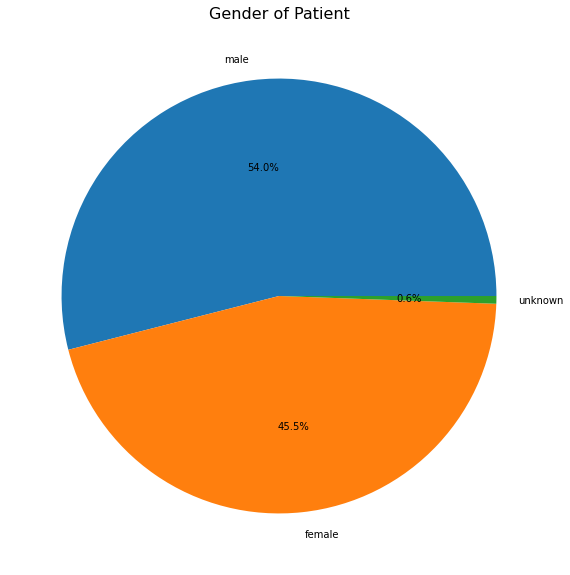

In [7]:
"""Distribution of Disease over Gender"""

bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

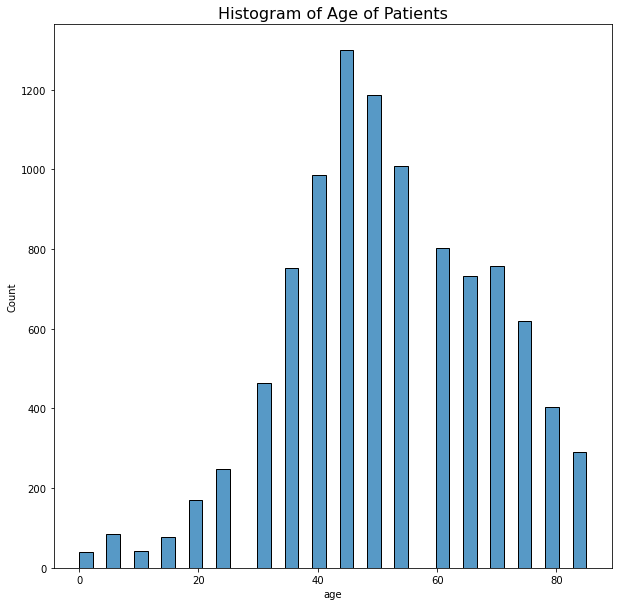

In [8]:
"""Histogram of Age of Patients"""

bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

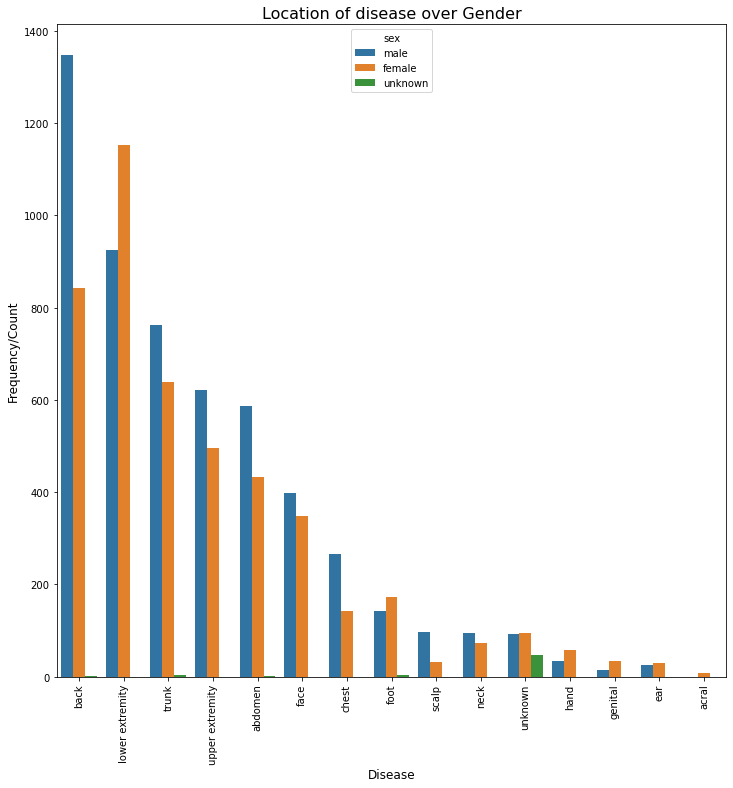

In [9]:
"""Location of disease over Gender"""

value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

In [10]:
# Oversampling

oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [11]:
"""Standardization and Splitting Data"""

x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [12]:
# Model Training

model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [13]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [25]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 25,
                    callbacks=[callback])

Epoch 1/25
235/235 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9843
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 33s 136ms/step - loss: 0.0443 - accuracy: 0.9843 - val_loss: 0.2448 - val_accuracy: 0.9538
Epoch 2/25
235/235 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9870
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 30s 129ms/step - loss: 0.0387 - accuracy: 0.9870 - val_loss: 0.1550 - val_accuracy: 0.9719
Epoch 3/25
235/235 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9962
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 31s 131ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.2521 - val_accuracy: 0.9601
Epoch 4/25
235/235 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9832
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 31s 131ms/step 

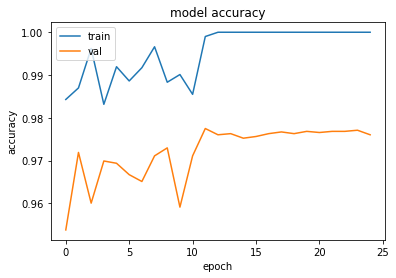

In [26]:
# Plot Accuracy and Loss
# Accuracy (training vs validation dataset)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

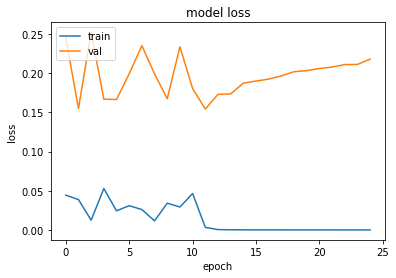

In [27]:
# Loss (training vs validation dataset)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
model.load_weights('best_model.h5')

In [29]:
# Model Testing

loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 2s - loss: 0.1867 - accuracy: 0.9792 - 2s/epoch - 7ms/step


In [19]:
# import matplotlib.pyplot as plt
# import cv2
# import os

# srcdir = r'C:\Users\Asus\Desktop\Project2\HAM10000_images_part_1'
# count = 0

# for temp in os.listdir(srcdir):
#     img = cv2.imread(os.path.join(srcdir, temp))
#     cv2.imwrite(os.path.join('HAM10000_images_part_2', temp), img)
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()
#     img = cv2.resize(img, (28, 28))
#     result = model.predict(img.reshape(1, 28, 28, 3))
#     max_prob = max(result[0])
#     class_ind = list(result[0]).index(max_prob)
#     class_name = classes[class_ind]
#     print(class_name)
#     count += 1
#     if count > 10:
#         break


In [20]:
# import matplotlib.pyplot as plt
# import cv2
# import os

# # List of disease names
# disease_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# # Dictionary to map class index to disease name
# class_to_disease = {
#     0: 'akiec', 1: 'bcc', 2: 'bkl',
#     3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'
# }

# # Source and destination directories
# srcdir = r'C:\Users\Asus\Desktop\Project2\HAM10000_images_part_1'
# dstdir = r'C:\Users\Asus\Desktop\Project2\HAM10000_images_part_2'

# # Load and predict on each disease folder
# for disease in disease_names:
#     count = 0
#     for filename in os.listdir(os.path.join(srcdir, disease)):
#         img = cv2.imread(os.path.join(srcdir, disease, filename))
#         cv2.imwrite(os.path.join(dstdir, filename), img)
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.show()
#         img = cv2.resize(img, (28, 28))
#         result = model.predict(img.reshape(1, 28, 28, 3))
#         max_prob = max(result[0])
#         class_ind = list(result[0]).index(max_prob)
#         class_name = classes[class_ind]
#         print(class_name)
#         count += 1
#         if count > 10:
#             break


1/1 [==============================] - 0s 22ms/step


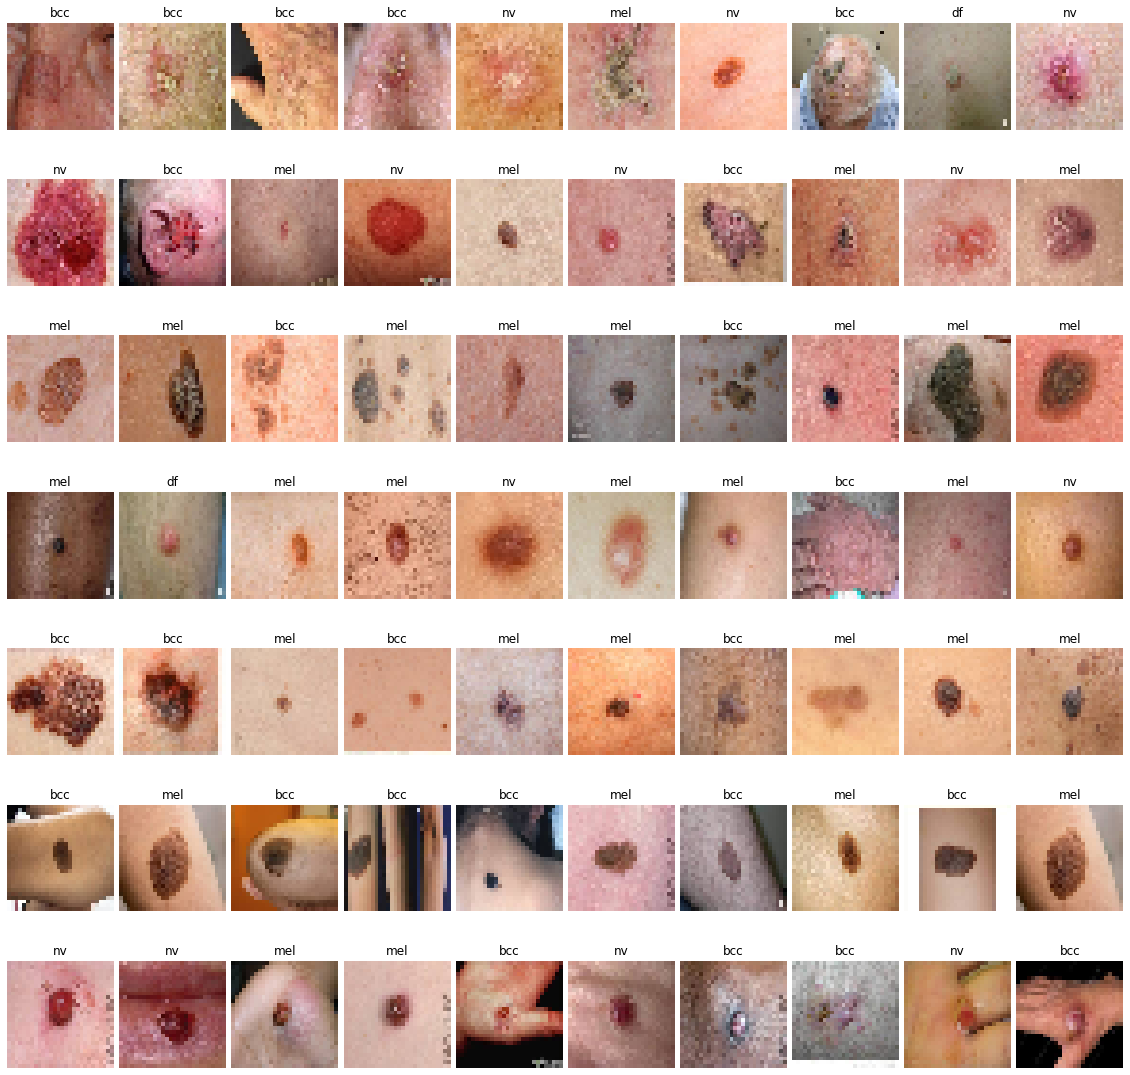

In [30]:
import matplotlib.pyplot as plt
import cv2
import os

srcdir = r'C:\Users\Asus\Desktop\Project2\HAM10000_images_part_1'
diseases = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
output_dir = r'C:\Users\Asus\Desktop\Project2\HAM10000_images_part_2'

fig = plt.figure(figsize=(20, 20))
count = 0

for disease in diseases:
    disease_dir = os.path.join(srcdir, disease)
    for temp in os.listdir(disease_dir):
        img = cv2.imread(os.path.join(disease_dir, temp))
        cv2.imwrite(os.path.join(output_dir, temp), img)
        img = cv2.resize(img, (28, 28))
        result = model.predict(img.reshape(1, 28, 28, 3))
        max_prob = max(result[0])
        class_ind = list(result[0]).index(max_prob)
        class_name = classes[class_ind]
        
        # Add image and disease name to subplot
        ax = fig.add_subplot(len(diseases), 10, count+1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(class_name)
        ax.axis('off')
        
        count += 1

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


1/1 [==============================] - 0s 29ms/step


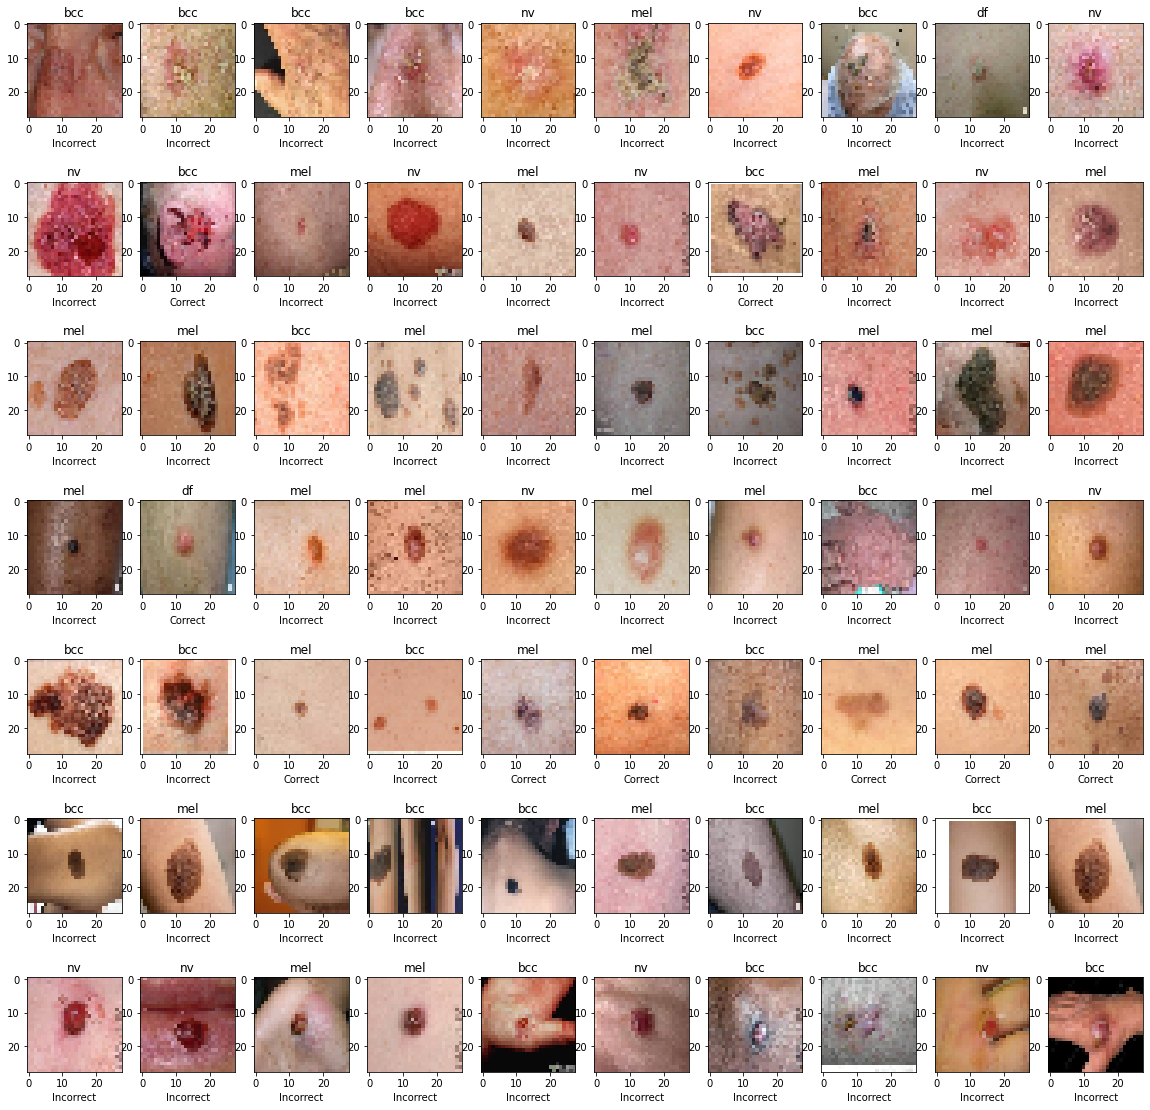

Results Table:

Disease Class	Correct		Incorrect
akiec		0.0		10.0
bcc		2.0		8.0
bkl		0.0		10.0
df		1.0		9.0
mel		6.0		4.0
nv		0.0		10.0
vasc		0.0		10.0


In [31]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

srcdir = r'C:\Users\Asus\Desktop\Project2\HAM10000_images_part_1'
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
output_dir = r'C:\Users\Asus\Desktop\Project2\HAM10000_images_part_2'

results = np.zeros((7, 2))

fig, ax = plt.subplots(nrows=7, ncols=10, figsize=(20, 20))

for i, disease_folder in enumerate(classes):
    count = 0
    for img_file in os.listdir(os.path.join(srcdir, disease_folder)):
        img_path = os.path.join(srcdir, disease_folder, img_file)
        img = cv2.imread(img_path)
        cv2.imwrite(os.path.join(output_dir, img_file), img)
        img = cv2.resize(img, (28, 28))
        result = model.predict(img.reshape(1, 28, 28, 3))
        max_prob = max(result[0])
        class_ind = list(result[0]).index(max_prob)
        class_name = classes[class_ind]
        ax[i, count].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i, count].set_title(class_name)
        if class_name == disease_folder:
            results[i][0] += 1
            ax[i, count].set_xlabel('Correct')
        else:
            results[i][1] += 1
            ax[i, count].set_xlabel('Incorrect')
        count += 1
        if count >= 10:
            break

plt.show()

print('Results Table:\n')
print('Disease Class\tCorrect\t\tIncorrect')
for i, disease_folder in enumerate(classes):
    print(f'{disease_folder}\t\t{results[i][0]}\t\t{results[i][1]}')


In [34]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the Keras model
model = load_model('best_model.h5')

# Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpk4m3y629\assets


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpk4m3y629\assets
